# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import numpy as np
import os
import datetime
from imageio import imread, imwrite
from skimage.transform import resize
import abc
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore")
import cv2

We set the random seed so that the results don't vary drastically.

In [3]:
import random as rn
from keras import backend as K
import tensorflow as tf

In [4]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.layers import LSTM
from keras.layers import Dropout

In [5]:
np.random.seed(30)
rn.seed(30)
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [6]:
input_data="Project_data"

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [7]:
class ModelBuilder(metaclass= abc.ABCMeta):
    
    def initialize_path(self,project_folder=input_data):
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path =  project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
        
    def initialize_image_properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
          
    def initialize_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs

    def generator(self, source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size = self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
            for batch in range(num_batches): # we iterate over the number of batches
                batch_data, batch_labels = self.per_batch_data(source_path, t, batch, batch_size, img_idx, augment)
                yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

            # write the code for the remaining data points which are left after full batches
            remaining_seq = len(t)%batch_size
            
            if(remaining_seq != 0):
                batch_data, batch_labels = self.per_batch_data(source_path, t, batch, batch_size, img_idx, augment, remaining_seq)
                yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


    def per_batch_data(self, source_path, t, batch, batch_size, img_idx, augment, remaining_seq = 0):
        if remaining_seq:
            seq_length = remaining_seq
        else:
            seq_length = batch_size

        batch_data = np.zeros((seq_length,len(img_idx),self.image_height,self.image_width,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
        batch_labels = np.zeros((seq_length,self.num_classes)) # batch_labels is the one hot representation of the output
        
        if (augment):
            batch_data_aug = np.zeros((seq_length,len(img_idx),self.image_height,self.image_width,self.channels))
            
        for folder in range(seq_length): # iterate over the batch_size
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
            for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                #crop the images and resize them. Note that the images are of 2 different shape 
                #and the conv3D will throw error if the inputs in a batch have different shapes
                image_resized = resize(image, (self.image_height, self.image_width, 3))

                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
                
                if (augment):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    image_resized=resize(cropped,(self.image_height,self.image_width,3))

                    batch_data_aug[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (image_resized[:,:,2])/255

            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])
            
        return(batch_data, batch_labels)

    def train_model(self, model, augment_data=False):
        # Let us create the train_generator and the val_generator which will be used in fit_generator
        train_generator = self.generator(self.train_path, self.train_doc, augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        callbacks_list = [checkpoint, LR]

        # The steps_per_epoch and validation_steps are used by fit_generator to decide the number of next() calls it need to make
        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1

        # Let us now fit the model. This will start training the model and with the help of the checkpoints,
        # you'll be able to save the model at the end of each epoch.
        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

        
    @abc.abstractmethod
    def define_model(self):
        pass

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [8]:
train_doc = np.random.permutation(open(input_data + '/' + 'train.csv').readlines())
val_doc = np.random.permutation(open(input_data + '/' + 'val.csv').readlines())
train_path = input_data + '/' + 'train'
val_path = input_data + '/' + 'val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
print('# training path = ', train_path)
print('# validation path = ', val_path)

# training sequences = 663
# validation sequences = 100
# training path =  Project_data/train
# validation path =  Project_data/val


### Helper Functions

In [9]:
def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
    axes[0].plot(history.history['loss'])
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss', 'val_loss'])
    axes[1].plot(history.history['categorical_accuracy'])
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy', 'val_categorical_accuracy'])

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

## Sample Model

In [13]:
#write your model here
class ModelConv3D(ModelBuilder):
    
    def define_model(self):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(128,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        model.add(Dense(64,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        # Compile the model
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        
        return model

In [14]:
conv_3d=ModelConv3D()
conv_3d.initialize_path()
conv_3d.initialize_image_properties(image_height=160,image_width=160)
conv_3d.initialize_hyperparams(frames_to_sample=20,batch_size=40,num_epochs=5)
conv_3d_model=conv_3d.define_model()
conv_3d_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 20, 160, 160, 16)  1312      
                                                                 
 activation (Activation)     (None, 20, 160, 160, 16)  0         
                                                                 
 batch_normalization (BatchN  (None, 20, 160, 160, 16)  64       
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 10, 80, 80, 16)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 10, 80, 80, 32)    4128      
                                                                 
 activation_1 (Activation)   (None, 10, 80, 80, 32)    0

In [29]:
print("Total Params:", conv_3d_model.count_params())
history_model = conv_3d.train_model(conv_3d_model)

Total Params: 1736389
Epoch 1/5
17/17 [==============================] - ETA: 0s - loss: 1.4681 - categorical_accuracy: 0.4646
Epoch 1: saving model to model_init_2022-06-1211_12_20.699656\model-00001-1.46811-0.46456-2.74981-0.15000.h5
17/17 [==============================] - 111s 7s/step - loss: 1.4681 - categorical_accuracy: 0.4646 - val_loss: 2.7498 - val_categorical_accuracy: 0.1500 - lr: 0.0010
Epoch 2/5
17/17 [==============================] - ETA: 0s - loss: 0.8939 - categorical_accuracy: 0.6486
Epoch 2: saving model to model_init_2022-06-1211_12_20.699656\model-00002-0.89394-0.64857-5.47298-0.17000.h5
17/17 [==============================] - 109s 7s/step - loss: 0.8939 - categorical_accuracy: 0.6486 - val_loss: 5.4730 - val_categorical_accuracy: 0.1700 - lr: 0.0010
Epoch 3/5
17/17 [==============================] - ETA: 0s - loss: 0.5938 - categorical_accuracy: 0.7768
Epoch 3: saving model to model_init_2022-06-1211_12_20.699656\model-00003-0.59378-0.77677-6.41717-0.19000.h5
17

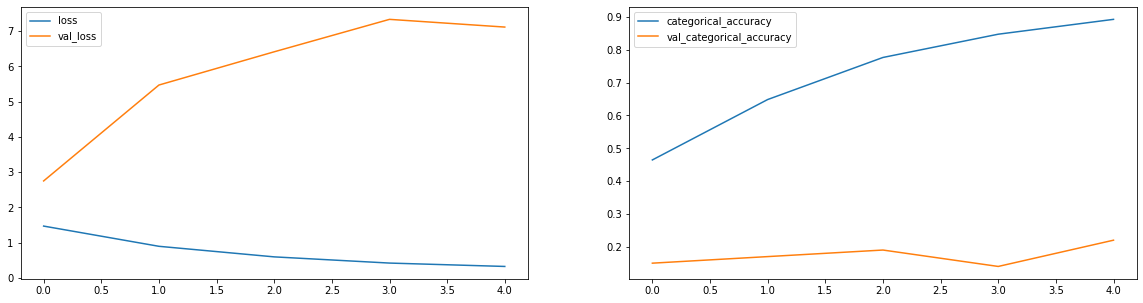

In [30]:
plot(history_model)

## Model 1 : Base model 
- image dimensions: 160x160
- frames to sample: 20
- batch size: 40
- number of epochs: 15

In [15]:
class ModelConv3D1(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        # Compile the model
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [16]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path()
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=20,batch_size=40,num_epochs=15)
conv_3d1_model=conv_3d1.define_model()
conv_3d1_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 20, 160, 160, 16)  1312      
                                                                 
 activation_4 (Activation)   (None, 20, 160, 160, 16)  0         
                                                                 
 batch_normalization_6 (Batc  (None, 20, 160, 160, 16)  64       
 hNormalization)                                                 
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 10, 80, 80, 16)   0         
 3D)                                                             
                                                                 
 conv3d_5 (Conv3D)           (None, 10, 80, 80, 32)    13856     
                                                                 
 activation_5 (Activation)   (None, 10, 80, 80, 32)   

In [33]:
print("Total Params:", conv_3d1_model.count_params())
history_model1 = conv_3d1.train_model(conv_3d1_model)

Total Params: 1117061
Epoch 1/15
17/17 [==============================] - ETA: 0s - loss: 1.4908 - categorical_accuracy: 0.4042
Epoch 1: saving model to model_init_2022-06-1211_21_33.436794\model-00001-1.49083-0.40422-1.49973-0.31000.h5
17/17 [==============================] - 112s 7s/step - loss: 1.4908 - categorical_accuracy: 0.4042 - val_loss: 1.4997 - val_categorical_accuracy: 0.3100 - lr: 0.0010
Epoch 2/15
17/17 [==============================] - ETA: 0s - loss: 0.9644 - categorical_accuracy: 0.6350
Epoch 2: saving model to model_init_2022-06-1211_21_33.436794\model-00002-0.96443-0.63499-2.33381-0.15000.h5
17/17 [==============================] - 110s 7s/step - loss: 0.9644 - categorical_accuracy: 0.6350 - val_loss: 2.3338 - val_categorical_accuracy: 0.1500 - lr: 0.0010
Epoch 3/15
17/17 [==============================] - ETA: 0s - loss: 0.5980 - categorical_accuracy: 0.8069
Epoch 3: saving model to model_init_2022-06-1211_21_33.436794\model-00003-0.59797-0.80694-2.35638-0.17000.h5

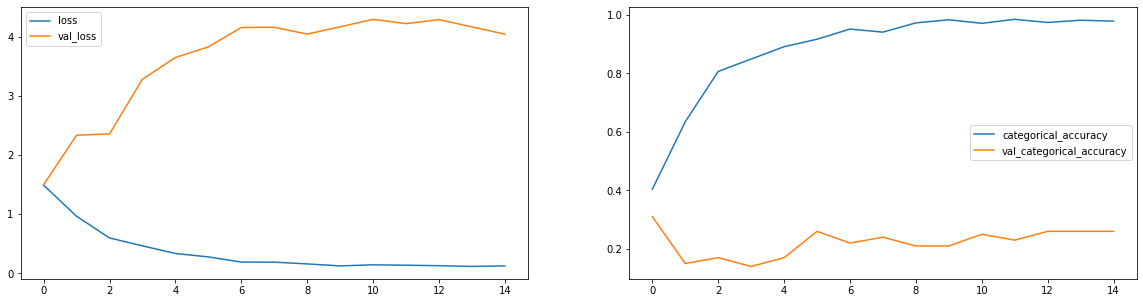

In [34]:
plot(history_model1)

## Model 2 : Base model with Augmented Data
- image dimensions: 160x160
- frames to sample: 20
- batch size: 20
- number of epochs: 25

In [17]:
conv_3d2=ModelConv3D1()
conv_3d2.initialize_path()
conv_3d2.initialize_image_properties(image_height=160,image_width=160)
conv_3d2.initialize_hyperparams(frames_to_sample=20,batch_size=20,num_epochs=25)
conv_3d2_model=conv_3d2.define_model(dense_neurons=256, dropout=0.5)
conv_3d2_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_8 (Conv3D)           (None, 20, 160, 160, 16)  1312      
                                                                 
 activation_8 (Activation)   (None, 20, 160, 160, 16)  0         
                                                                 
 batch_normalization_12 (Bat  (None, 20, 160, 160, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_8 (MaxPooling  (None, 10, 80, 80, 16)   0         
 3D)                                                             
                                                                 
 conv3d_9 (Conv3D)           (None, 10, 80, 80, 32)    13856     
                                                                 
 activation_9 (Activation)   (None, 10, 80, 80, 32)   

In [19]:
print("Total Params:", conv_3d2_model.count_params())
history_model2 = conv_3d2.train_model(conv_3d2_model, augment_data=True)

Total Params: 3638981
Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 1.9494 - categorical_accuracy: 0.3884
Epoch 1: saving model to model_init_2022-06-1218_53_52.235117\model-00001-1.94937-0.38839-3.79442-0.16000.h5
34/34 [==============================] - 198s 6s/step - loss: 1.9494 - categorical_accuracy: 0.3884 - val_loss: 3.7944 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.5242 - categorical_accuracy: 0.4578
Epoch 2: saving model to model_init_2022-06-1218_53_52.235117\model-00002-1.52418-0.45777-5.65032-0.23000.h5
34/34 [==============================] - 199s 6s/step - loss: 1.5242 - categorical_accuracy: 0.4578 - val_loss: 5.6503 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 1.1756 - categorical_accuracy: 0.5799
Epoch 3: saving model to model_init_2022-06-1218_53_52.235117\model-00003-1.17559-0.57994-9.22710-0.18000.h5

34/34 [==============================] - 196s 6s/step - loss: 0.2935 - categorical_accuracy: 0.8906 - val_loss: 0.3513 - val_categorical_accuracy: 0.8600 - lr: 4.0000e-05
Epoch 22/25
34/34 [==============================] - ETA: 0s - loss: 0.2584 - categorical_accuracy: 0.9050
Epoch 22: saving model to model_init_2022-06-1218_53_52.235117\model-00022-0.25837-0.90498-0.39040-0.84000.h5
34/34 [==============================] - 196s 6s/step - loss: 0.2584 - categorical_accuracy: 0.9050 - val_loss: 0.3904 - val_categorical_accuracy: 0.8400 - lr: 4.0000e-05
Epoch 23/25
34/34 [==============================] - ETA: 0s - loss: 0.2739 - categorical_accuracy: 0.9057
Epoch 23: saving model to model_init_2022-06-1218_53_52.235117\model-00023-0.27395-0.90573-0.33175-0.86000.h5
34/34 [==============================] - 197s 6s/step - loss: 0.2739 - categorical_accuracy: 0.9057 - val_loss: 0.3317 - val_categorical_accuracy: 0.8600 - lr: 4.0000e-05
Epoch 24/25
34/34 [==============================] - 

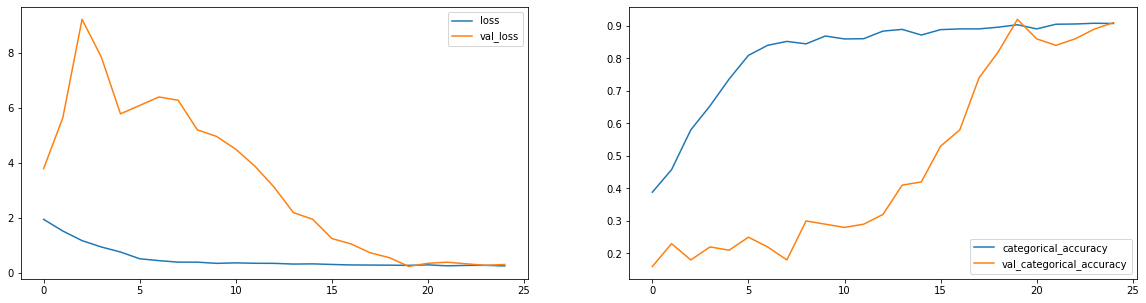

In [22]:
plot(history_model2)

## Model 3: Reducing the number of parameters

In [18]:
class ModelConv3D3(ModelBuilder):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        # Compile the model
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [19]:
conv_3d3=ModelConv3D3()
conv_3d3.initialize_path()
conv_3d3.initialize_image_properties(image_height=100,image_width=100)
conv_3d3.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=30)
conv_3d3_model=conv_3d3.define_model(dense_neurons=128, dropout=0.25)
conv_3d3_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_12 (Conv3D)          (None, 16, 100, 100, 16)  1312      
                                                                 
 activation_12 (Activation)  (None, 16, 100, 100, 16)  0         
                                                                 
 batch_normalization_18 (Bat  (None, 16, 100, 100, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_12 (MaxPoolin  (None, 8, 50, 50, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_13 (Conv3D)          (None, 8, 50, 50, 32)     4128      
                                                                 
 activation_13 (Activation)  (None, 8, 50, 50, 32)    

In [25]:
print("Total Params:", conv_3d3_model.count_params())
history_model3 = conv_3d3.train_model(conv_3d3_model, augment_data=True)

Total Params: 696645
Epoch 1/30
34/34 [==============================] - ETA: 0s - loss: 1.6499 - categorical_accuracy: 0.4170
Epoch 1: saving model to model_init_2022-06-1309_53_44.520991\model-00001-1.64991-0.41704-1.98401-0.16000.h5
34/34 [==============================] - 110s 3s/step - loss: 1.6499 - categorical_accuracy: 0.4170 - val_loss: 1.9840 - val_categorical_accuracy: 0.1600 - lr: 2.0000e-04
Epoch 2/30
33/34 [============================>.] - ETA: 2s - loss: 1.0563 - categorical_accuracy: 0.5879
Epoch 2: saving model to model_init_2022-06-1309_53_44.520991\model-00002-1.06090-0.58748-2.78168-0.17000.h5
34/34 [==============================] - 107s 3s/step - loss: 1.0609 - categorical_accuracy: 0.5875 - val_loss: 2.7817 - val_categorical_accuracy: 0.1700 - lr: 2.0000e-04
Epoch 3/30
34/34 [==============================] - ETA: 0s - loss: 0.7955 - categorical_accuracy: 0.6991
Epoch 3: saving model to model_init_2022-06-1309_53_44.520991\model-00003-0.79547-0.69910-3.94766-0.1

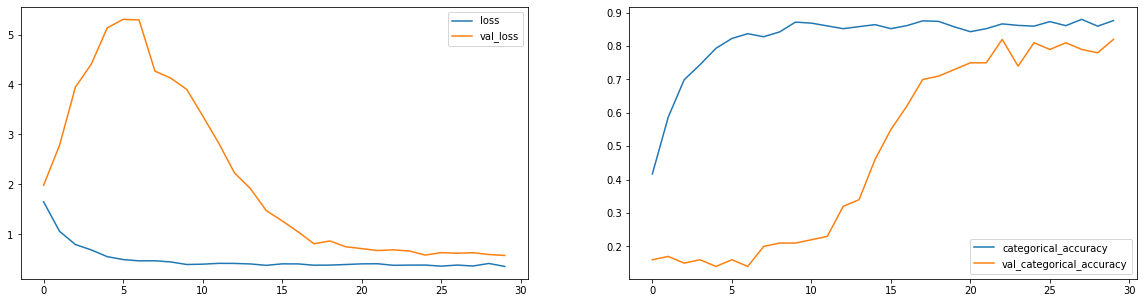

In [26]:
plot(history_model3)

## Model 4: Further Reducing the number of parameters

In [20]:
class ModelConv3D4(ModelBuilder):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(8, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(16, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        # Compile the model        
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [21]:
conv_3d4=ModelConv3D4()
conv_3d4.initialize_path()
conv_3d4.initialize_image_properties(image_height=120,image_width=120)
conv_3d4.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=30)
conv_3d4_model=conv_3d4.define_model(dense_neurons=64,dropout=0.25)
conv_3d4_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_16 (Conv3D)          (None, 16, 120, 120, 8)   656       
                                                                 
 activation_16 (Activation)  (None, 16, 120, 120, 8)   0         
                                                                 
 batch_normalization_24 (Bat  (None, 16, 120, 120, 8)  32        
 chNormalization)                                                
                                                                 
 max_pooling3d_16 (MaxPoolin  (None, 8, 60, 60, 8)     0         
 g3D)                                                            
                                                                 
 conv3d_17 (Conv3D)          (None, 8, 60, 60, 16)     3472      
                                                                 
 activation_17 (Activation)  (None, 8, 60, 60, 16)    

In [14]:
print("Total Params:", conv_3d4_model.count_params())
history_model4 = conv_3d4.train_model(conv_3d4_model, augment_data=True)

Total Params: 230949
Epoch 1/30
34/34 [==============================] - ETA: 0s - loss: 1.9188 - categorical_accuracy: 0.3077
Epoch 1: saving model to model_init_2022-06-1321_16_37.613659\model-00001-1.91885-0.30769-1.69213-0.21000.h5
34/34 [==============================] - 124s 3s/step - loss: 1.9188 - categorical_accuracy: 0.3077 - val_loss: 1.6921 - val_categorical_accuracy: 0.2100 - lr: 2.0000e-04
Epoch 2/30
34/34 [==============================] - ETA: 0s - loss: 1.4179 - categorical_accuracy: 0.4623
Epoch 2: saving model to model_init_2022-06-1321_16_37.613659\model-00002-1.41789-0.46229-2.07912-0.21000.h5
34/34 [==============================] - 118s 4s/step - loss: 1.4179 - categorical_accuracy: 0.4623 - val_loss: 2.0791 - val_categorical_accuracy: 0.2100 - lr: 2.0000e-04
Epoch 3/30
34/34 [==============================] - ETA: 0s - loss: 1.1692 - categorical_accuracy: 0.5422
Epoch 3: saving model to model_init_2022-06-1321_16_37.613659\model-00003-1.16922-0.54223-2.82189-0.2

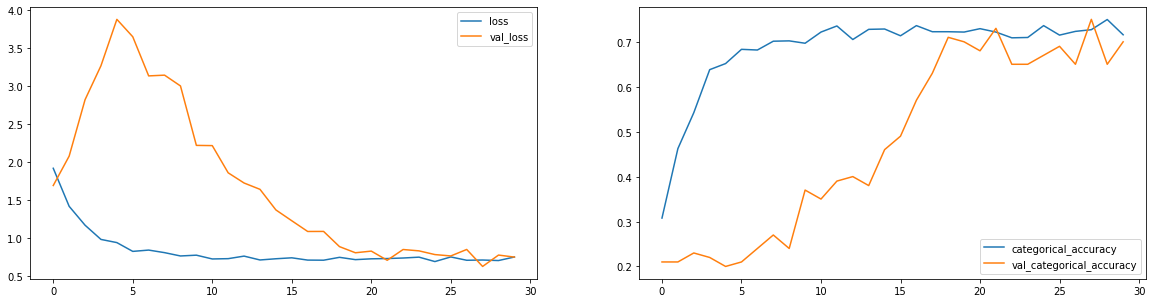

In [15]:
plot(history_model4)

## Model 5: CNN and LSTM Model

In [22]:
class RNNCNN1(ModelBuilder):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Flatten()))

        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [23]:
rnn_cnn1=RNNCNN1()
rnn_cnn1.initialize_path()
rnn_cnn1.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn1.initialize_hyperparams(frames_to_sample=18,batch_size=20,num_epochs=20)
rnn_cnn1_model=rnn_cnn1.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn1_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 18, 120, 120, 16)  448      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 18, 120, 120, 16)  64       
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 18, 60, 60, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 18, 60, 60, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 18, 60, 60, 32)  

In [21]:
print("Total Params:", rnn_cnn1_model.count_params())
history_model5 = rnn_cnn1.train_model(rnn_cnn1_model,augment_data=True)

Total Params: 1657445
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.3708 - categorical_accuracy: 0.4012
Epoch 1: saving model to model_init_2022-06-1322_27_06.097245\model-00001-1.37078-0.40121-1.58889-0.31000.h5
34/34 [==============================] - 141s 4s/step - loss: 1.3708 - categorical_accuracy: 0.4012 - val_loss: 1.5889 - val_categorical_accuracy: 0.3100 - lr: 0.0010
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.0326 - categorical_accuracy: 0.5943
Epoch 2: saving model to model_init_2022-06-1322_27_06.097245\model-00002-1.03260-0.59427-1.79021-0.16000.h5
34/34 [==============================] - 133s 4s/step - loss: 1.0326 - categorical_accuracy: 0.5943 - val_loss: 1.7902 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 0.9058 - categorical_accuracy: 0.6508
Epoch 3: saving model to model_init_2022-06-1322_27_06.097245\model-00003-0.90575-0.65083-2.06577-0.24000.h5

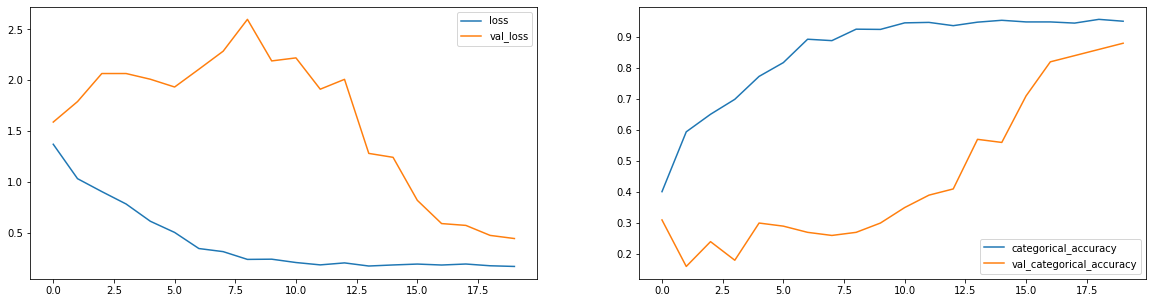

In [22]:
plot(history_model5)

## More Augmentation

In [10]:
class ModelBuilderMoreAugmentation(metaclass= abc.ABCMeta):
    
    def initialize_path(self,project_folder=input_data):
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path =  project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
        
    def initialize_image_properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
          
    def initialize_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs

    def generator(self, source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size = self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
            for batch in range(num_batches): # we iterate over the number of batches
                batch_data, batch_labels = self.per_batch_data(source_path, t, batch, batch_size, img_idx, augment)
                yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

            # write the code for the remaining data points which are left after full batches
            remaining_seq = len(t)%batch_size
            
            if(remaining_seq != 0):
                batch_data, batch_labels = self.per_batch_data(source_path, t, batch, batch_size, img_idx, augment, remaining_seq)
                yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


    def per_batch_data(self, source_path, t, batch, batch_size, img_idx, augment, remaining_seq = 0):
        if remaining_seq:
            seq_length = remaining_seq
        else:
            seq_length = batch_size

        batch_data = np.zeros((seq_length,len(img_idx),self.image_height,self.image_width,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
        batch_labels = np.zeros((seq_length,self.num_classes)) # batch_labels is the one hot representation of the output
        
        if (augment):
            batch_data_aug = np.zeros((seq_length,len(img_idx),self.image_height,self.image_width,self.channels))
            
        for folder in range(seq_length): # iterate over the batch_size
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
            for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                #crop the images and resize them. Note that the images are of 2 different shape 
                #and the conv3D will throw error if the inputs in a batch have different shapes
                image_resized = resize(image, (self.image_height, self.image_width, 3))

                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
                
                if (augment):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    image_resized=resize(cropped,(self.image_height,self.image_width,3))
                    
                    M = cv2.getRotationMatrix2D((self.image_width//2,self.image_height//2),
                                                np.random.randint(-10,10), 1.0)
                    rotated = cv2.warpAffine(image_resized, M, (self.image_width, self.image_height))

                    batch_data_aug[folder,idx,:,:,0] = (rotated[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (rotated[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (rotated[:,:,2])/255

            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])
            
        return(batch_data, batch_labels)

    def train_model(self, model, augment_data=False):
        # Let us create the train_generator and the val_generator which will be used in fit_generator
        train_generator = self.generator(self.train_path, self.train_doc, augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        callbacks_list = [checkpoint, LR]

        # The steps_per_epoch and validation_steps are used by fit_generator to decide the number of next() calls it need to make
        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1

        # Let us now fit the model. This will start training the model and with the help of the checkpoints,
        # you'll be able to save the model at the end of each epoch.
        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

        
    @abc.abstractmethod
    def define_model(self):
        pass

## Model 6 : Base model with More Augmentation
- image dimensions: 160x160
- frames to sample: 20
- batch size: 20
- number of epochs: 30

In [25]:
class ModelConv3D6(ModelBuilderMoreAugmentation):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        # Compile the model
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [26]:
conv_3d6=ModelConv3D6()
conv_3d6.initialize_path()
conv_3d6.initialize_image_properties(image_height=160,image_width=160)
conv_3d6.initialize_hyperparams(frames_to_sample=20,batch_size=20,num_epochs=30)
conv_3d6_model=conv_3d6.define_model(dense_neurons=256, dropout=0.5)
conv_3d6_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_20 (Conv3D)          (None, 20, 160, 160, 16)  1312      
                                                                 
 activation_20 (Activation)  (None, 20, 160, 160, 16)  0         
                                                                 
 batch_normalization_35 (Bat  (None, 20, 160, 160, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_20 (MaxPoolin  (None, 10, 80, 80, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_21 (Conv3D)          (None, 10, 80, 80, 32)    13856     
                                                                 
 activation_21 (Activation)  (None, 10, 80, 80, 32)   

In [26]:
print("Total Params:", conv_3d6_model.count_params())
history_model6 = conv_3d6.train_model(conv_3d6_model, augment_data=True)

Total Params: 3638981
Epoch 1/30
34/34 [==============================] - ETA: 0s - loss: 1.8893 - categorical_accuracy: 0.4012
Epoch 1: saving model to model_init_2022-06-1323_11_21.823796\model-00001-1.88926-0.40121-3.07023-0.19000.h5
34/34 [==============================] - 200s 6s/step - loss: 1.8893 - categorical_accuracy: 0.4012 - val_loss: 3.0702 - val_categorical_accuracy: 0.1900 - lr: 0.0010
Epoch 2/30
34/34 [==============================] - ETA: 0s - loss: 1.2947 - categorical_accuracy: 0.5468
Epoch 2: saving model to model_init_2022-06-1323_11_21.823796\model-00002-1.29472-0.54676-3.14708-0.26000.h5
34/34 [==============================] - 197s 6s/step - loss: 1.2947 - categorical_accuracy: 0.5468 - val_loss: 3.1471 - val_categorical_accuracy: 0.2600 - lr: 0.0010
Epoch 3/30
34/34 [==============================] - ETA: 0s - loss: 0.9952 - categorical_accuracy: 0.6584
Epoch 3: saving model to model_init_2022-06-1323_11_21.823796\model-00003-0.99521-0.65837-5.04389-0.15000.h5

34/34 [==============================] - 195s 6s/step - loss: 0.2609 - categorical_accuracy: 0.9072 - val_loss: 0.4045 - val_categorical_accuracy: 0.8700 - lr: 4.0000e-05
Epoch 22/30
34/34 [==============================] - ETA: 0s - loss: 0.1876 - categorical_accuracy: 0.9306
Epoch 22: saving model to model_init_2022-06-1323_11_21.823796\model-00022-0.18760-0.93062-0.28770-0.93000.h5
34/34 [==============================] - 196s 6s/step - loss: 0.1876 - categorical_accuracy: 0.9306 - val_loss: 0.2877 - val_categorical_accuracy: 0.9300 - lr: 4.0000e-05
Epoch 23/30
34/34 [==============================] - ETA: 0s - loss: 0.2278 - categorical_accuracy: 0.9148
Epoch 23: saving model to model_init_2022-06-1323_11_21.823796\model-00023-0.22780-0.91478-0.32225-0.92000.h5
34/34 [==============================] - 196s 6s/step - loss: 0.2278 - categorical_accuracy: 0.9148 - val_loss: 0.3222 - val_categorical_accuracy: 0.9200 - lr: 4.0000e-05
Epoch 24/30
34/34 [==============================] - 

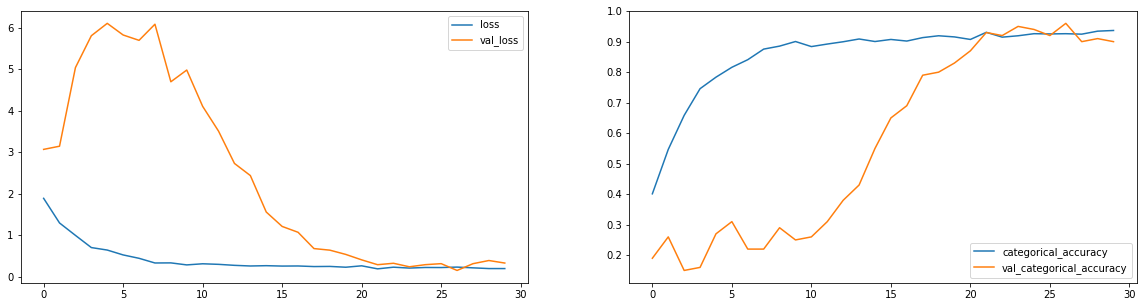

In [27]:
plot(history_model6)

## Model 7: Model 3 with More Augmentation

In [27]:
class ModelConv3D7(ModelBuilderMoreAugmentation):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        # Compile the model
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [28]:
conv_3d7=ModelConv3D7()
conv_3d7.initialize_path()
conv_3d7.initialize_image_properties(image_height=100,image_width=100)
conv_3d7.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=30)
conv_3d7_model=conv_3d7.define_model(dense_neurons=128, dropout=0.25)
conv_3d7_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_24 (Conv3D)          (None, 16, 100, 100, 16)  1312      
                                                                 
 activation_24 (Activation)  (None, 16, 100, 100, 16)  0         
                                                                 
 batch_normalization_41 (Bat  (None, 16, 100, 100, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_24 (MaxPoolin  (None, 8, 50, 50, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_25 (Conv3D)          (None, 8, 50, 50, 32)     4128      
                                                                 
 activation_25 (Activation)  (None, 8, 50, 50, 32)    

In [30]:
print("Total Params:", conv_3d7_model.count_params())
history_model7 = conv_3d7.train_model(conv_3d7_model, augment_data=True)

Total Params: 696645
Epoch 1/30
34/34 [==============================] - ETA: 0s - loss: 1.7669 - categorical_accuracy: 0.3597
Epoch 1: saving model to model_init_2022-06-1400_50_02.527094\model-00001-1.76688-0.35973-1.94231-0.18000.h5
34/34 [==============================] - 107s 3s/step - loss: 1.7669 - categorical_accuracy: 0.3597 - val_loss: 1.9423 - val_categorical_accuracy: 0.1800 - lr: 2.0000e-04
Epoch 2/30
33/34 [============================>.] - ETA: 2s - loss: 1.1292 - categorical_accuracy: 0.5492
Epoch 2: saving model to model_init_2022-06-1400_50_02.527094\model-00002-1.13060-0.54902-2.38702-0.19000.h5
34/34 [==============================] - 106s 3s/step - loss: 1.1306 - categorical_accuracy: 0.5490 - val_loss: 2.3870 - val_categorical_accuracy: 0.1900 - lr: 2.0000e-04
Epoch 3/30
34/34 [==============================] - ETA: 0s - loss: 0.9418 - categorical_accuracy: 0.6275
Epoch 3: saving model to model_init_2022-06-1400_50_02.527094\model-00003-0.94180-0.62745-3.28386-0.2

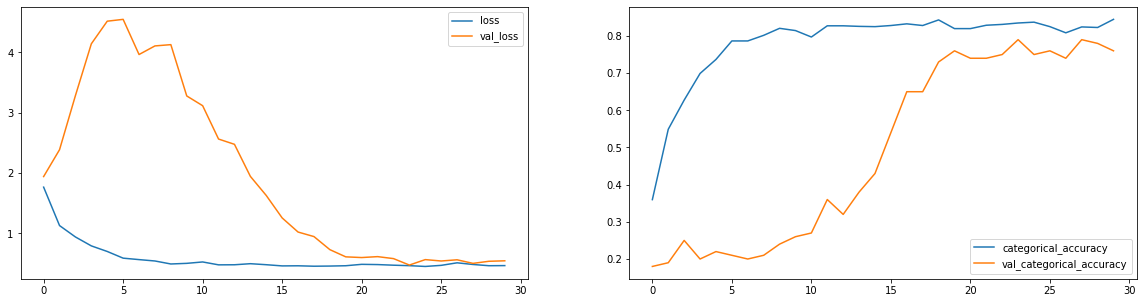

In [31]:
plot(history_model7)

## Model 8: Model 4 with More Augmentation

In [29]:
class ModelConv3D8(ModelBuilderMoreAugmentation):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(8, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(16, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        # Compile the model        
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [30]:
conv_3d8=ModelConv3D8()
conv_3d8.initialize_path()
conv_3d8.initialize_image_properties(image_height=120,image_width=120)
conv_3d8.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=30)
conv_3d8_model=conv_3d8.define_model(dense_neurons=64,dropout=0.25)
conv_3d8_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_28 (Conv3D)          (None, 16, 120, 120, 8)   656       
                                                                 
 activation_28 (Activation)  (None, 16, 120, 120, 8)   0         
                                                                 
 batch_normalization_47 (Bat  (None, 16, 120, 120, 8)  32        
 chNormalization)                                                
                                                                 
 max_pooling3d_28 (MaxPoolin  (None, 8, 60, 60, 8)     0         
 g3D)                                                            
                                                                 
 conv3d_29 (Conv3D)          (None, 8, 60, 60, 16)     3472      
                                                                 
 activation_29 (Activation)  (None, 8, 60, 60, 16)    

In [34]:
print("Total Params:", conv_3d8_model.count_params())
history_model8 = conv_3d8.train_model(conv_3d8_model, augment_data=True)

Total Params: 230949
Epoch 1/30
34/34 [==============================] - ETA: 0s - loss: 1.8342 - categorical_accuracy: 0.3183
Epoch 1: saving model to model_init_2022-06-1401_43_14.090914\model-00001-1.83420-0.31825-2.13330-0.16000.h5
34/34 [==============================] - 120s 4s/step - loss: 1.8342 - categorical_accuracy: 0.3183 - val_loss: 2.1333 - val_categorical_accuracy: 0.1600 - lr: 2.0000e-04
Epoch 2/30
33/34 [============================>.] - ETA: 3s - loss: 1.3982 - categorical_accuracy: 0.4386
Epoch 2: saving model to model_init_2022-06-1401_43_14.090914\model-00002-1.40172-0.43665-3.34533-0.17000.h5
34/34 [==============================] - 118s 4s/step - loss: 1.4017 - categorical_accuracy: 0.4367 - val_loss: 3.3453 - val_categorical_accuracy: 0.1700 - lr: 2.0000e-04
Epoch 3/30
34/34 [==============================] - ETA: 0s - loss: 1.2276 - categorical_accuracy: 0.5189
Epoch 3: saving model to model_init_2022-06-1401_43_14.090914\model-00003-1.22757-0.51885-4.19744-0.1

34/34 [==============================] - 118s 4s/step - loss: 0.7835 - categorical_accuracy: 0.7059 - val_loss: 0.6802 - val_categorical_accuracy: 0.7700 - lr: 8.0000e-06
Epoch 22/30
34/34 [==============================] - ETA: 0s - loss: 0.7949 - categorical_accuracy: 0.7029
Epoch 22: saving model to model_init_2022-06-1401_43_14.090914\model-00022-0.79492-0.70287-0.65425-0.82000.h5
34/34 [==============================] - 118s 4s/step - loss: 0.7949 - categorical_accuracy: 0.7029 - val_loss: 0.6542 - val_categorical_accuracy: 0.8200 - lr: 8.0000e-06
Epoch 23/30
34/34 [==============================] - ETA: 0s - loss: 0.7740 - categorical_accuracy: 0.6983
Epoch 23: saving model to model_init_2022-06-1401_43_14.090914\model-00023-0.77396-0.69834-0.68900-0.81000.h5
34/34 [==============================] - 118s 4s/step - loss: 0.7740 - categorical_accuracy: 0.6983 - val_loss: 0.6890 - val_categorical_accuracy: 0.8100 - lr: 8.0000e-06
Epoch 24/30
34/34 [==============================] - 

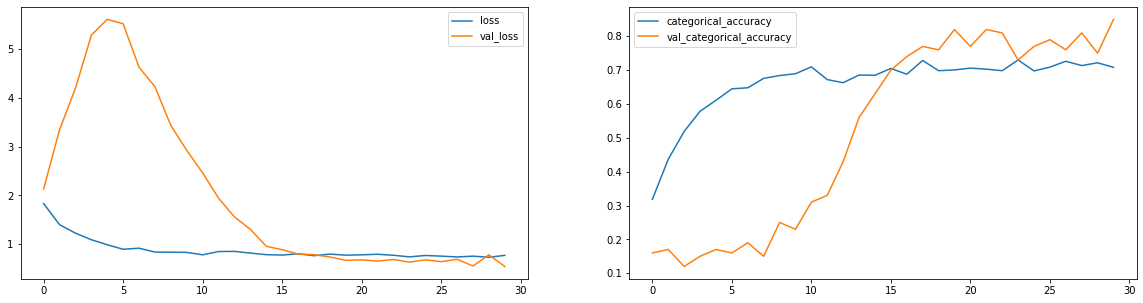

In [35]:
plot(history_model8)

## Model 9: CNN with GRU - More Augmentation

In [31]:
class RNNCNN2(ModelBuilderMoreAugmentation):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        

        model.add(TimeDistributed(Flatten()))


        model.add(GRU(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        optimiser = optimizers.Adam(lr=0.0002)
        # Compile the model
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [32]:
rnn_cnn2=RNNCNN2()
rnn_cnn2.initialize_path()
rnn_cnn2.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn2.initialize_hyperparams(frames_to_sample=18,batch_size=20,num_epochs=20)
rnn_cnn2_model=rnn_cnn2.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn2_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_16 (TimeDi  (None, 18, 120, 120, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_17 (TimeDi  (None, 18, 120, 120, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_18 (TimeDi  (None, 18, 60, 60, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_19 (TimeDi  (None, 18, 60, 60, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_20 (TimeDi  (None, 18, 60, 60, 32)  

In [39]:
print("Total Params:", rnn_cnn2_model.count_params())
history_model9=rnn_cnn2.train_model(rnn_cnn2_model,augment_data=True)

Total Params: 2573925
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.3800 - categorical_accuracy: 0.4223
Epoch 1: saving model to model_init_2022-06-1407_45_17.677699\model-00001-1.38001-0.42232-1.67607-0.21000.h5
34/34 [==============================] - 135s 4s/step - loss: 1.3800 - categorical_accuracy: 0.4223 - val_loss: 1.6761 - val_categorical_accuracy: 0.2100 - lr: 2.0000e-04
Epoch 2/20
33/34 [============================>.] - ETA: 3s - loss: 0.9014 - categorical_accuracy: 0.6561
Epoch 2: saving model to model_init_2022-06-1407_45_17.677699\model-00002-0.89961-0.65686-2.23406-0.22000.h5
34/34 [==============================] - 132s 4s/step - loss: 0.8996 - categorical_accuracy: 0.6569 - val_loss: 2.2341 - val_categorical_accuracy: 0.2200 - lr: 2.0000e-04
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 0.7134 - categorical_accuracy: 0.7421
Epoch 3: saving model to model_init_2022-06-1407_45_17.677699\model-00003-0.71338-0.74208-2.40432-0.

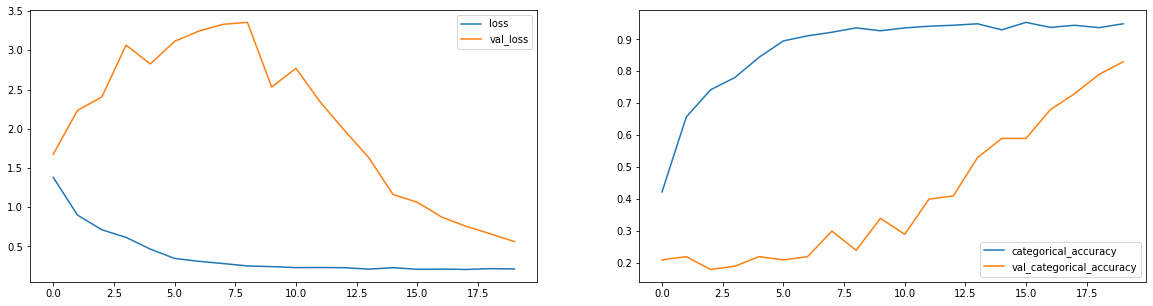

In [40]:
plot(history_model9)

## Model 10: Transfer Learning with LSTM - Pretrained

In [11]:
from keras.applications import mobilenet

In [34]:
mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

In [35]:
class RNNCNN_TL1(ModelBuilderMoreAugmentation):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):
        
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        
        for layer in model.layers:
            layer.trainable = False
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        
        optimiser = optimizers.Adam()
        # Compile model
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [36]:
rnn_cnn_tl1=RNNCNN_TL1()
rnn_cnn_tl1.initialize_path()
rnn_cnn_tl1.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn_tl1.initialize_hyperparams(frames_to_sample=16,batch_size=5,num_epochs=20)
rnn_cnn_tl1_model=rnn_cnn_tl1.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn_tl1_model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_29 (TimeDi  (None, 16, 3, 3, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_30 (TimeDi  (None, 16, 3, 3, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_31 (TimeDi  (None, 16, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_32 (TimeDi  (None, 16, 1024)         0         
 stributed)                                                      
                                                                 
 lstm_1 (LSTM)               (None, 128)             

In [54]:
print("Total Params:", rnn_cnn_tl1_model.count_params())
history_model10=rnn_cnn_tl1.train_model(rnn_cnn_tl1_model,augment_data=True)

Total Params: 3840453
Epoch 1/20
133/133 [==============================] - ETA: 0s - loss: 1.1926 - categorical_accuracy: 0.5128
Epoch 1: saving model to model_init_2022-06-1422_41_12.826612\model-00001-1.19258-0.51282-0.82606-0.69000.h5
133/133 [==============================] - 127s 944ms/step - loss: 1.1926 - categorical_accuracy: 0.5128 - val_loss: 0.8261 - val_categorical_accuracy: 0.6900 - lr: 0.0010
Epoch 2/20
133/133 [==============================] - ETA: 0s - loss: 0.7126 - categorical_accuracy: 0.7308
Epoch 2: saving model to model_init_2022-06-1422_41_12.826612\model-00002-0.71263-0.73077-0.61440-0.79000.h5
133/133 [==============================] - 123s 932ms/step - loss: 0.7126 - categorical_accuracy: 0.7308 - val_loss: 0.6144 - val_categorical_accuracy: 0.7900 - lr: 0.0010
Epoch 3/20
133/133 [==============================] - ETA: 0s - loss: 0.4978 - categorical_accuracy: 0.8220
Epoch 3: saving model to model_init_2022-06-1422_41_12.826612\model-00003-0.49778-0.82202-0.

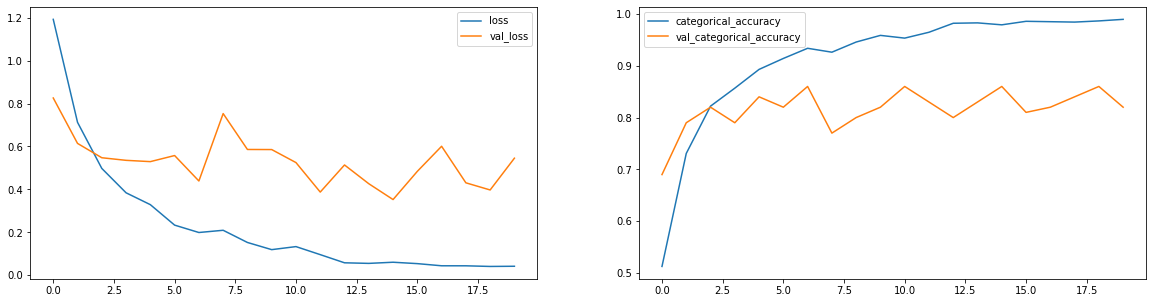

In [55]:
plot(history_model10)

## Model 11: Transfer Learning with GRU and training all weights

In [12]:
mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)
class RNNCNN_TL2(ModelBuilderMoreAugmentation):
    
    def define_model(self,gru_cells=64,dense_neurons=64,dropout=0.25):
        
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
 
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(GRU(gru_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        
        optimiser = optimizers.Adam()
        # compile model
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [13]:
rnn_cnn_tl2=RNNCNN_TL2()
rnn_cnn_tl2.initialize_path()
rnn_cnn_tl2.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn_tl2.initialize_hyperparams(frames_to_sample=16,batch_size=5,num_epochs=20)
rnn_cnn_tl2_model=rnn_cnn_tl2.define_model(gru_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn_tl2_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 16, 3, 3, 1024)   3228864   
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 16, 3, 3, 1024)   4096      
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 16, 1, 1, 1024)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 16, 1024)         0         
 tributed)                                                       
                                                                 
 gru (GRU)                   (None, 128)               4

In [14]:
print("Total Params:", rnn_cnn_tl2_model.count_params())
history_model11=rnn_cnn_tl2.train_model(rnn_cnn_tl2_model,augment_data=True)

Total Params: 3693253
Epoch 1/20
133/133 [==============================] - ETA: 0s - loss: 0.8233 - categorical_accuracy: 0.6931
Epoch 1: saving model to model_init_2022-06-1520_27_06.336119\model-00001-0.82327-0.69306-0.66109-0.76000.h5
133/133 [==============================] - 140s 987ms/step - loss: 0.8233 - categorical_accuracy: 0.6931 - val_loss: 0.6611 - val_categorical_accuracy: 0.7600 - lr: 0.0010
Epoch 2/20
133/133 [==============================] - ETA: 0s - loss: 0.4067 - categorical_accuracy: 0.8718
Epoch 2: saving model to model_init_2022-06-1520_27_06.336119\model-00002-0.40670-0.87179-0.22366-0.93000.h5
133/133 [==============================] - 122s 918ms/step - loss: 0.4067 - categorical_accuracy: 0.8718 - val_loss: 0.2237 - val_categorical_accuracy: 0.9300 - lr: 0.0010
Epoch 3/20
133/133 [==============================] - ETA: 0s - loss: 0.2466 - categorical_accuracy: 0.9238
Epoch 3: saving model to model_init_2022-06-1520_27_06.336119\model-00003-0.24658-0.92383-0.

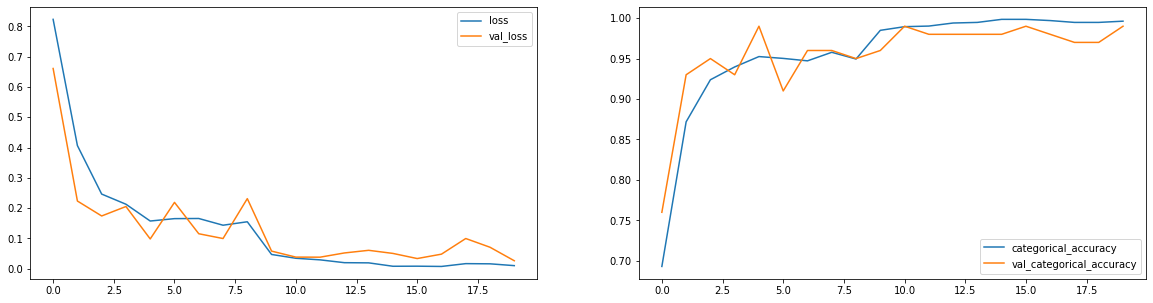

In [15]:
plot(history_model11)